# <u><center>Backtesting investment strategies - CAC 40 Case</center></u>

The constructed portfolio in this notebook is a mix of stocks and safe assets ( cash-assimilated ) .  

1/The considered universe of stocks will be that of the french index CAC 40 . Suppose I'm an investor trying to <b>outperform CAC 40</b> . What weight should I assign to each stock so as to achieve this goal ? This is the purpose of this project : I'm going to backtest different investment strategies on historical data , given the CAC 40 universe . 

2/Once the right construction technique selected , I'm going to apply the CPPI strategy on the constructed portfolio and a selected safe asset : The CPPI strategy is a <b>risk-averse</b> strategy that allows you to avoid extreme losses . This strategy requires 2 elements : 
- the return series of the risky part of your portfolio , which here is the CAC 40 benchmarked constructed portfolio in step 1 
- the return series of a safe asset 

The CPPI strategy's mission is to determine the weights of each constituant ( risky CAC 40 benchmarked portfolio and the safe asset ) such that no more than x % loss is tolerated , during the investment horizon . The weights are not determined once and kept for the whole time period : the CPPI strategy rebalances the allocation periodically to ensure the max drawdown constraint is not violated. 

Data Source : Yahoo Finance / Boursier.com . I'm going to perform web scraping to automate retrieving data : components of CAC 40 , return series of each stock ,   their market caps .. 

<u>Remarks:</u> 

--> CAC 40 components vary over time , although not very often  . To simplify and because there's no available ( free ) history of the components , I'm going to consider a static universe of stocks ( the one as of the time of the code execution ).  

--> Yahoo Finance only displays top 30 components of CAC 40 . Also , the composition displayed doesn't seem to be reliable     ( e.g : Accor SA left CAC 40 since Sept 2020 but still shows in the composition list ) . A more reliable and complete composition I found is on Boursier.com ( same that shows on abcbourse website ) . However , the returns series of each stock will be retrieved from Yahoo Finance since it shows the longest history ( Backtesting needs as much history as possible as we need to account for an estimation window , e.g : if we consider an estimation window of 36 months then 3 years worth of data is not enough to roll and perform backtesting ). We need a list of the corresponding  Yahoo Finance tickers : there's no option other than manually creating the list, as the components table we're going to use is not the one provided by Yahoo Finance ( which shows the tickers ) . Once the list created , importing the return series will be done with web scraping . 

 
<font color='red'><b>FINAL NOTE<b></font> : This is an application of what I've learned in Investment Management with Python and Machine Learning Specialization offered through Coursera . Neither the CPPI strategy , nor any of the construction techniques tested is an innovation of mine . 

### Retrieving and cleaning Data

In [1]:
# web scrape CAC 40 components
import pandas as pd 
import requests 
url_components='https://www.boursier.com/indices/composition/cac-40-FR0003500008,FR.html'
headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.5060.114 Safari/537.36'}
response = requests.get(url_components ,headers=headers) 
df=pd.read_html(response.content)[0]

In [2]:
Composition = df['Valeur']
Composition

0                   AIR LIQUIDE
1                  AIRBUS GROUP
2                        ALSTOM
3                 ARCELORMITTAL
4                           AXA
5                   BNP PARIBAS
6                      BOUYGUES
7                     CAPGEMINI
8                     CARREFOUR
9               CREDIT AGRICOLE
10                       DANONE
11            DASSAULT SYSTEMES
12                        ENGIE
13             ESSILORLUXOTTICA
14          EUROFINS SCIENTIFIC
15         HERMES INTERNATIONAL
16                       KERING
17                      LEGRAND
18                      L'OREAL
19                         LVMH
20                     MICHELIN
21                       ORANGE
22                PERNOD RICARD
23                     PUBLICIS
24                      RENAULT
25                       SAFRAN
26                 SAINT-GOBAIN
27                       SANOFI
28           SCHNEIDER ELECTRIC
29             SOCIETE GENERALE
30                   STELLANTIS
31      

In [3]:
# searching for all Yahoo Finance tickers and gathering them in an excel table 
tickers=pd.read_excel('yf tickers.xlsx')['ticker']
composition_tk=pd.concat([Composition,tickers],axis=1)
composition_tk.head()

,Valeur,ticker
0,AIR LIQUIDE,AI.PA
1,AIRBUS GROUP,AIR.PA
2,ALSTOM,ALO.PA
3,ARCELORMITTAL,MT.AS
4,AXA,CS.PA


In [4]:
# Retrieving the price series of each stock as well as of CAC 40 .The Data is daily . 
# pip install pandas-datareader
# pip install yfinance

from pandas_datareader import data as pdr
import yfinance

lst=[]

for ticker in composition_tk['ticker']:
    stock = pdr.get_data_yahoo(ticker, start='2005-01-01', end='2022-01-01')[['Close']]
    lst.append(stock)
stocks_r=pd.concat(lst,axis=1) 

In [5]:
stocks_r.columns=composition_tk['Valeur']
stocks_r.head()

Valeur,AIR LIQUIDE,AIRBUS GROUP,ALSTOM,ARCELORMITTAL,AXA,BNP PARIBAS,BOUYGUES,CAPGEMINI,CARREFOUR,CREDIT AGRICOLE,...,STELLANTIS,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAIL-RODAMCO-WESTFIELD,VEOLIA ENVIRONNEMENT,VINCI,VIVENDI SE,WORLDLINE
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,31.859020,21.559999,NaN,NaN,17.279615,53.144321,34.430000,24.090000,35.360001,19.563360,...,NaN,14.30,18.041382,35.500000,40.150002,114.500000,26.352068,24.595184,23.380651,NaN
2005-01-04,31.859020,21.160000,NaN,NaN,17.279615,53.540184,34.689999,23.850000,35.619999,19.519594,...,NaN,14.22,18.135347,35.419998,40.000000,110.300003,25.850592,24.840647,23.758072,NaN
2005-01-05,31.508921,20.980000,NaN,NaN,17.279615,53.243286,34.349998,23.820000,35.400002,19.633387,...,NaN,14.02,18.229313,35.299999,39.625000,110.500000,25.880091,24.742462,23.661297,NaN
2005-01-06,31.602280,21.600000,NaN,NaN,17.279615,54.035007,30.240000,23.670000,35.730000,19.782190,...,NaN,13.97,18.793106,35.720001,39.924999,110.599998,26.155411,25.086107,23.535492,NaN
2005-01-07,31.812340,21.920000,NaN,NaN,17.279615,54.628799,30.180000,23.379999,36.250000,19.957253,...,NaN,14.03,19.450865,35.130001,40.049999,92.050003,26.116077,25.208838,23.564524,NaN


In [6]:
stocks_r['2010':].isnull().sum()

Valeur
AIR LIQUIDE                     3
AIRBUS GROUP                    3
ALSTOM                          3
ARCELORMITTAL                   2
AXA                             3
BNP PARIBAS                     3
BOUYGUES                        3
CAPGEMINI                       3
CARREFOUR                       3
CREDIT AGRICOLE                 3
DANONE                          3
DASSAULT SYSTEMES               3
ENGIE                           3
ESSILORLUXOTTICA                3
EUROFINS SCIENTIFIC             3
HERMES INTERNATIONAL            3
KERING                          3
LEGRAND                         3
L'OREAL                         3
LVMH                            3
MICHELIN                        3
ORANGE                          3
PERNOD RICARD                   3
PUBLICIS                        3
RENAULT                         3
SAFRAN                          3
SAINT-GOBAIN                    3
SANOFI                          3
SCHNEIDER ELECTRIC              3
SOCIETE

Stellantis got listed on Euronext in 2021 and Worldline in 2015 --> Stellantis should be dropped from the universe , or else the investment horizon will be too short (less than  1 year ) making it impossible to backtest . 
After dropping Stellantis , we have 2 options : 
- either keep Wordline but work on a period of 7 years ( 2015 - 2022 ) 
- Or drop Wordline and thus work on <font color='red'>38 stocks of the CAC 40 Universe</font> , but on a longer period ( 12 years ) . 

I'm going to go for the 2nd option as the longer the period of backtesting is , the more reliable the results are . 


In [7]:
stocks=stocks_r.drop(['STELLANTIS','WORLDLINE'],axis=1)['2010':]
stocks_final=stocks.dropna(axis=0)
stocks_final.isnull().sum()

Valeur
AIR LIQUIDE                  0
AIRBUS GROUP                 0
ALSTOM                       0
ARCELORMITTAL                0
AXA                          0
BNP PARIBAS                  0
BOUYGUES                     0
CAPGEMINI                    0
CARREFOUR                    0
CREDIT AGRICOLE              0
DANONE                       0
DASSAULT SYSTEMES            0
ENGIE                        0
ESSILORLUXOTTICA             0
EUROFINS SCIENTIFIC          0
HERMES INTERNATIONAL         0
KERING                       0
LEGRAND                      0
L'OREAL                      0
LVMH                         0
MICHELIN                     0
ORANGE                       0
PERNOD RICARD                0
PUBLICIS                     0
RENAULT                      0
SAFRAN                       0
SAINT-GOBAIN                 0
SANOFI                       0
SCHNEIDER ELECTRIC           0
SOCIETE GENERALE             0
STMICROELECTRONICS           0
TELEPERFORMANCE              0
T

In [8]:
cac = pdr.get_data_yahoo( '^FCHI', start='2010-01-01', end='2022-01-01')[['Close']]
cac.head()

,Close
Date,
2010-01-04,4013.969971
2010-01-05,4012.909912
2010-01-06,4017.669922
2010-01-07,4024.800049
2010-01-08,4045.139893


In [9]:
cac.columns=['CAC 40']
df_final=cac.merge(stocks_final,on='Date')
df_final.head()
# Final prices Dataset (Daily data from 2010 - 2021 both inclusive ) 

,CAC 40,AIR LIQUIDE,AIRBUS GROUP,ALSTOM,ARCELORMITTAL,AXA,BNP PARIBAS,BOUYGUES,CAPGEMINI,CARREFOUR,...,SCHNEIDER ELECTRIC,SOCIETE GENERALE,STMICROELECTRONICS,TELEPERFORMANCE,THALES,TOTALENERGIES,UNIBAIL-RODAMCO-WESTFIELD,VEOLIA ENVIRONNEMENT,VINCI,VIVENDI SE
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,4013.969971,47.727844,13.990,51.520000,68.004936,16.799999,57.240002,37.020000,33.349998,34.000000,...,41.224998,50.240002,6.476,23.150000,35.520000,45.794991,155.300003,23.350000,39.974991,20.719360
2010-01-05,4012.909912,46.773289,13.945,51.660000,67.363091,17.080000,57.130001,37.474991,33.764999,34.805000,...,41.025002,49.915001,6.475,23.695000,34.814999,45.849998,155.100006,23.530001,40.279999,20.714521
2010-01-06,4017.669922,46.485226,14.070,51.970001,66.853691,17.254999,57.220001,37.674999,34.435001,34.549999,...,40.605000,49.919998,6.551,23.400000,34.369999,45.880001,156.449997,23.875000,40.834999,20.491941
2010-01-07,4024.800049,46.428745,14.210,52.130001,68.086441,17.059999,58.220001,37.160000,34.075001,34.160000,...,40.525002,51.310001,6.467,23.639999,34.794991,45.959999,154.800003,24.155001,40.849998,20.429037
2010-01-08,4045.139893,46.575600,14.350,53.150002,68.565277,17.115000,59.599998,37.174999,34.220001,34.494999,...,40.160000,52.080002,6.443,23.830000,35.410000,46.009998,154.850006,25.100000,41.430000,20.187103


### PART I : CAC 40 Quick Analysis

This is live data : means that , if you ever run the code ,  the analysis depends on the time of the code execution ( the market caps are not static : 
there's no available history of the market caps  ) . But there shoudn't be much difference.  We're going to web scrape some data from Boursier.com to get the ( live ) market caps and sectors of the components of CAC 40 . 

In [10]:
# web scrape stocks' sectors and market caps
import lxml
import html5lib
import bs4


soup=bs4.BeautifulSoup(response.text,'html.parser')
hrefs=soup.find_all('td',{'class':'tl'})
lst_marktcap=[]
lst_sector=[]
for href in hrefs:
    ref=href.find_all('a')[0]
    url_stock='https://www.boursier.com'+ref['href']
    res_marktcap = requests.get(url_stock,headers=headers) 
    df_marktcap=pd.read_html(res_marktcap.content)
    lst_marktcap.append(df_marktcap[0].loc[6][1])
    url_sector=url_stock.replace('cours','societe/profil')
    res_sector=requests.get(url_sector,headers=headers)
    df_sector=pd.read_html(res_sector.content)
    lst_sector.append(df_sector[2][1].loc[0])


In [11]:
sector_marktcap=pd.DataFrame({'Company': Composition , 'Sector': lst_sector,'Market Cap' : lst_marktcap})
sector_marktcap

,Company,Sector,Market Cap
0,AIR LIQUIDE,Energie et Produits de base,"71,6 Md€"
1,AIRBUS GROUP,Aéronautique Espace Armement,"85,31 Md€"
2,ALSTOM,Autres biens d'équipement,"9,06 Md€"
3,ARCELORMITTAL,Transformation des métaux,"21,21 Md€"
4,AXA,Assurances,"56,88 Md€"
5,BNP PARIBAS,Banque,"61,35 Md€"
6,BOUYGUES,Conglomérat,"11,71 Md€"
7,CAPGEMINI,Services informatiques,"32,56 Md€"
8,CARREFOUR,Distribution générale grand public,"12,67 Md€"
9,CREDIT AGRICOLE,Banque,"30,23 Md€"


In [12]:
#transform the format of market cap column to numerical
Market_cap_Md=sector_marktcap['Market Cap'].str.split(pat="\xa0").str.get(0).str.replace(',','.').astype(float)
Market_cap_Md

0      71.60
1      85.31
2       9.06
3      21.21
4      56.88
5      61.35
6      11.71
7      32.56
8      12.67
9      30.23
10     36.05
11     57.52
12     31.33
13     73.87
14     14.94
15    146.16
16     69.92
17     21.68
18    194.16
19    350.52
20     18.98
21     26.94
22     50.21
23     12.89
24      9.00
25     47.33
26     23.80
27    108.18
28     77.50
29     19.93
30     46.05
31     34.08
32     18.72
33     25.83
34    132.24
35      8.46
36     17.67
37     56.23
38     10.40
39     12.48
Name: Market Cap, dtype: float64

In [13]:
import numpy as np
df_analysis=sector_marktcap.drop(['Market Cap'],axis=1)
df_analysis['Market Cap (Md€)']=Market_cap_Md
df_analysis['Weight']=np.round(df_analysis['Market Cap (Md€)']*100/df_analysis['Market Cap (Md€)'].sum(),1)

In [14]:
df_analysis.head()

,Company,Sector,Market Cap (Md€),Weight
0,AIR LIQUIDE,Energie et Produits de base,71.60,3.3
1,AIRBUS GROUP,Aéronautique Espace Armement,85.31,4.0
2,ALSTOM,Autres biens d'équipement,9.06,0.4
3,ARCELORMITTAL,Transformation des métaux,21.21,1.0
4,AXA,Assurances,56.88,2.7


In [15]:
# determine top 5 companies 
cacsorted=df_analysis.sort_values(by=['Market Cap (Md€)'],ascending=False)
cacsorted.head()

,Company,Sector,Market Cap (Md€),Weight
19,LVMH,Conglomérat,350.52,16.3
18,L'OREAL,Chimie Pharmacie Cosmétiques,194.16,9.0
15,HERMES INTERNATIONAL,Textile Habillement Accessoires,146.16,6.8
34,TOTALENERGIES,Energie et Produits de base,132.24,6.2
27,SANOFI,Chimie Pharmacie Cosmétiques,108.18,5.0


In [16]:
# pip install plotly-express
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)        # in case plotly graphs go blank at the time of code execution 

In [17]:
import plotly.express as px


fig1 = px.bar(cacsorted.head(5),
            x=cacsorted.head(5)['Weight'],
            y=cacsorted.head(5)['Company'],
             labels=dict(x="Weight (%) ",y='Company'),
            orientation='h',color='Company',color_discrete_sequence=['DarkCyan','LightSeaGreen','CadetBlue',
                                                                     'LightSteelBlue','LightBlue']).update_traces(width=0.5)

fig1.update_layout(plot_bgcolor='white',title=dict(
        text='<b>CAC 40 : Top 5 companies by Market Cap</b> ',
        x=0.55,
        y=0.95,
        font=dict(
            size=18,
        color='Black')),
   yaxis=dict(autorange="reversed",linecolor='Black',tickfont=dict(size=14)),
                   xaxis=dict(title_font_size=15,color='Black',linecolor='Black',tickfont=dict(size=14)),
                  showlegend=False,yaxis_title=None,bargap=0.1)

fig1.show()


In [18]:
# Decomposition :   By sector and company 
# First , determine the top 7 sectors 
df_analysis1=df_analysis.replace(['Banque','Assurances'],'Banque & Assurances')

top7sectors=df_analysis1.drop(['Company','Weight'],axis=1).groupby(by='Sector').sum().sort_values(by='Market Cap (Md€)'
                                                        ,ascending=False).head(7).squeeze()
# Any sector other than the top 7 will be marked as 'others' 
others = df_analysis1.drop(df_analysis1[df_analysis1['Sector'].isin(top7sectors.index)].index)
df_analysis2=df_analysis1.replace(pd.concat([others['Company'],others['Sector']]).tolist(),'Autres')

In [19]:
df_analysis2.head()

,Company,Sector,Market Cap (Md€),Weight
0,AIR LIQUIDE,Energie et Produits de base,71.60,3.3
1,AIRBUS GROUP,Aéronautique Espace Armement,85.31,4.0
2,Autres,Autres,9.06,0.4
3,Autres,Autres,21.21,1.0
4,AXA,Banque & Assurances,56.88,2.7


In [20]:
fig2= px.sunburst(df_analysis2, path=['Sector', 'Company'],values='Market Cap (Md€)',width=800, height=700)
fig2.update_layout(title = dict(
        text='<b>CAC 40 by Sector and Company </b> ',
        x=0.5,
        y=0.95,
        font=dict(size=18,color='Black')))
fig2.show()

In [21]:
# Now , out of daily prices , compute the monthly returns 

rets=df_final.pct_change().dropna().resample('M').apply(lambda x:(1+x).prod()-1)
rets.index=rets.index.to_period('M')
rets_comp=rets.drop(['CAC 40'],axis=1)

# Determine annualized returns and vols : 
ann_ret=(1+rets_comp).prod()**(12/rets_comp.shape[0])-1
ann_vol=rets_comp.std()*np.sqrt(12)

top5perf=ann_ret.sort_values(ascending=False).head(5)
least5vol=ann_vol.sort_values().head(5)

In [22]:
top5perf

EUROFINS SCIENTIFIC     0.316364
TELEPERFORMANCE         0.265886
HERMES INTERNATIONAL    0.262571
DASSAULT SYSTEMES       0.237882
LVMH                    0.203548
dtype: float64

In [23]:
least5vol

L'OREAL          0.149932
DANONE           0.159292
AIR LIQUIDE      0.160658
SANOFI           0.178113
PERNOD RICARD    0.179793
dtype: float64

In [24]:
# Pick up an approximation of the risk free rate
# Source : stats.oecd.org 
rf=pd.read_csv('EURIBOR-3M.csv')[['Value']]/100
rf.index=rets.index
rf.columns=['Rf']    # rf for Risk Free rate 
rf.head()

,Rf
Date,
2010-01,0.006797
2010-02,0.006617
2010-03,0.006450
2010-04,0.006447
2010-05,0.006865


In [25]:
excess_rets=rets_comp.sub(rf.squeeze(),axis='index')    # using the minus does not solve the problem

# annualize the excess rets and then divide by annualized vol
excess_rets=(1+excess_rets).prod()**(12/excess_rets.shape[0])-1
top5sr=(excess_rets/ann_vol).sort_values(ascending=False).head(5)
top5sr

DASSAULT SYSTEMES       1.138915
TELEPERFORMANCE         1.108810
EUROFINS SCIENTIFIC     1.094586
HERMES INTERNATIONAL    1.034445
L'OREAL                 0.910663
dtype: float64

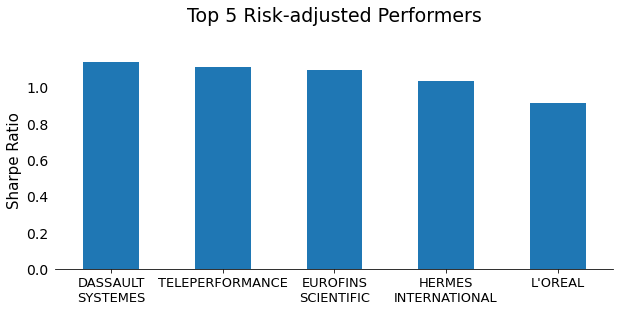

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,4))
ax=top5sr.plot.bar(rot=0)
plt.xticks(fontsize=13,)
plt.yticks(fontsize=14)
plt.xlim(-0.5, None)
plt.tick_params(left=False)
sns.despine(left=True)
plt.title('Top 5 Risk-adjusted Performers',fontsize=19,pad=30)
plt.ylabel('Sharpe Ratio',fontsize=15)
# If label made of 2 words , go back to the line 
def wrap_xlabels(ax):
        new_labels=[label._text.replace(" ","\n")  for label in ax.get_xticklabels()]
        ax.set_xticklabels(new_labels)
wrap_xlabels(ax)
# end

plt.show()


In [27]:
# Analyze the behavior of CAC 40 components regarding the market : Which stocks amplify market movements and which have a more 
# defensive behavior ? 
import statsmodels.api as sm
pd.options.mode.chained_assignment = None   # Suspend warning
lst_b=[]
y=rets['CAC 40']
for stock in rets_comp.columns:
    x=rets[[stock]]
    x['Constant']=1
    lst_b.append(round(sm.OLS(y,x).fit().params[0],4))
    

In [28]:
betas=pd.DataFrame(data=lst_b,index=rets_comp.columns,columns=['OLS Beta'])
betas[betas['OLS Beta']>1]

,OLS Beta


In [29]:
betas[betas['OLS Beta']<0]

,OLS Beta


We conclude that all stocks are more or less defensive but no one is <b>deccorelated</b> with the market ( beta < 0) neither <b>agressive</b> ( > 1 ) . 

In [31]:
# Categorize stocks according to their betas : at first , the categories intended were : agressive , defensive and decorrelated.
# Since all stocks are defensive , we're going to categorize them relatively ,  as less defensive , most defensive and medium . 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # Suspend warning

category=pd.Series().reindex_like(betas)
category.iloc[np.where(betas['OLS Beta']>=0.6)[0]]="Least Defensive"
category.iloc[np.where((betas['OLS Beta']<0.6) & (betas['OLS Beta']>0.3))[0]]="Medium"
category.iloc[np.where(betas['OLS Beta']<=0.3)[0]]="Most defensive"

betas['Category']=category
betas.head()

,OLS Beta,Category
AIR LIQUIDE,0.6771,Least Defensive
AIRBUS GROUP,0.3621,Medium
ALSTOM,0.2841,Most defensive
ARCELORMITTAL,0.2199,Most defensive
AXA,0.4576,Medium


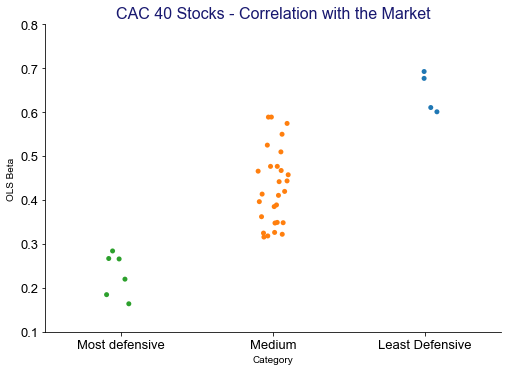

In [32]:
import matplotlib.pyplot as plt
fig=sns.catplot(x="Category", y="OLS Beta", data=betas, aspect=10/7)
sns.set_theme(font_scale=1.2)
plt.title("CAC 40 Stocks - Correlation with the Market" , fontdict={'fontsize':16,'color':'midnightblue'},loc='center')
fig.set_yticklabels(size=13)
fig.set_xticklabels(size=13)
sns.set_style('white')
plt.gca().invert_xaxis()
plt.show()

In [33]:
# Gathering all the information above in a synthetic and interactive figure 



# First , define a function to plot hlines as it will be called 2 times
def hline_plot(ax,rank_series):
    if (rank_series.values==top5perf.values).all(): 
        title,x_label='Top 5 Performers','Annualized return'
    else:
        title,x_label= '5 Least Volatile','Annualized Vol'
        
    ax.hlines(y=rank_series.index, xmin=0, xmax=rank_series, color='midnightblue')
    ax.plot(rank_series, rank_series.index, 'o', color='slateblue')   # add scatter points
    ax.set_xlim(0)
    ax.invert_yaxis()    # reverse order of y-axis so that least volatile appears first and top performer appears first
    ax.set_title(title,fontdict={'fontsize':24,'color':'midnightblue','fontweight':'medium'},pad=20)
    # format to % the x axis tick labels
    vals = ax.get_xticks()[:-1]
    ax.set_xticks(vals)   
    ax.set_xticklabels(['{:,.1%}'.format(x) for x in vals])
    # end 
    ax.set_xlabel(x_label,fontdict={'fontsize':23},labelpad=20)
    ax.tick_params(axis='both',labelsize=19,bottom=True)
    sns.despine(left=True)

In [34]:
# Second , define a synthetic function that gathers all plots to be able to use it in the widgets interact function
def interactive_plot(n_years): 
    '''this function returns the subplots . n_years is the interactive parameter '''
    # Computation 
    y=12*int(n_years[0]) if n_years!='Max' else 1+rets_comp.shape[0]
    rets_comp1=rets_comp.iloc[-1-y:]
    rf1=rf.iloc[-1-y:]
    
    ann_ret=(1+rets_comp1).prod()**(12/rets_comp1.shape[0])-1
    top5perf=ann_ret.sort_values(ascending=False).head(5)
    ann_vol=rets_comp1.std()*np.sqrt(12)
    least5vol=ann_vol.sort_values().head(5)
    excess_rets=rets_comp1.sub(rf1.squeeze(),axis='index')    
    excess_rets=(1+excess_rets).prod()**(12/excess_rets.shape[0])-1
    top5sr=(excess_rets/ann_vol).sort_values(ascending=False).head(5)
    
    # Figure 
    fig,[[ax1,ax2],[ax3,ax4]]=plt.subplots(2,2,figsize=(25,18))
    fig.suptitle("CAC 40 - Synthetic Analysis", fontsize=28,fontweight='semibold',color='DarkBlue')
    plt.subplots_adjust(wspace=0.5,right=1)
    plt.subplots_adjust(hspace=0.7)


    # 1st plot 
    hline_plot(ax1,top5perf)

    # 2nd plot 
    hline_plot(ax2,least5vol)


    # 3rd plot
    lst=['olive' if i>=1 else 'blue' for i in top5sr]   # color the bars in green if sharpe ratio exceeds 1
    top5sr.plot.bar(ax=ax3,width=0.4,rot=45,color=lst,alpha=0.5)
    ax3.set_xlim(-0.6,None)
    sns.despine(left=True)
    ax3.set_title('Top 5 Risk-adjusted Performers',fontdict={'fontsize':24,'color':'midnightblue','fontweight':'medium'},pad=30)
    ax3.set_ylabel('Annualized Sharpe Ratio',fontdict={'fontsize':20},labelpad=20)
    # if xtick label exceeds a word , go back to the line 
    def wrap_xlabels(ax):
            new_labels=[label._text.replace(" ","\n")  for label in ax.get_xticklabels()]
            ax.set_xticklabels(new_labels)
    wrap_xlabels(ax3)
    # end 
    ax3.tick_params(axis='x',labelsize=20)
    ax3.tick_params(axis='y',labelsize=22)

    # 4th plot  ( the stripplot is equivalent to the catplot displayed above , only that the catplot cannot be a subplot  )
    ax4=sns.stripplot(x="Category", y="OLS Beta", data=betas,size=12)  
    ax4.invert_xaxis()
    ax4.set_title("CAC 40 Stocks - Correlation with the Market \n(Max Period)" , fontdict={'fontsize':24,'color':'midnightblue','fontweight':'medium'}
                                                                                ,pad = 30 , loc='center')
    ax4.tick_params(axis='both',labelsize=20)
    ax4.set_xlabel('Category',fontdict={'fontsize':22},labelpad=30)
    ax4.set_ylabel('OLS Beta',fontdict={'fontsize':22},labelpad=30)



    plt.show()

In [ ]:
# pip install ipywidgets 

In [35]:
import ipywidgets as widgets 

widgets.interact(interactive_plot,n_years=widgets.Dropdown(options=['3 Years','5 Years','Max'],description='Go Back',value='Max'))

interactive(children=(Dropdown(description='Go Back', index=2, options=('3 Years', '5 Years', 'Max'), value='Max'), Output()), _dom_classes=('widget-interact',))

<function __main__.interactive_plot(n_years)>

Unfortunately , ipywidgets cannot be displayed on github . However , if you download the notebook and run it, you can view widgets and interact with the plot . Here is just <b><u>a screenshot of the output</u></b>  : 

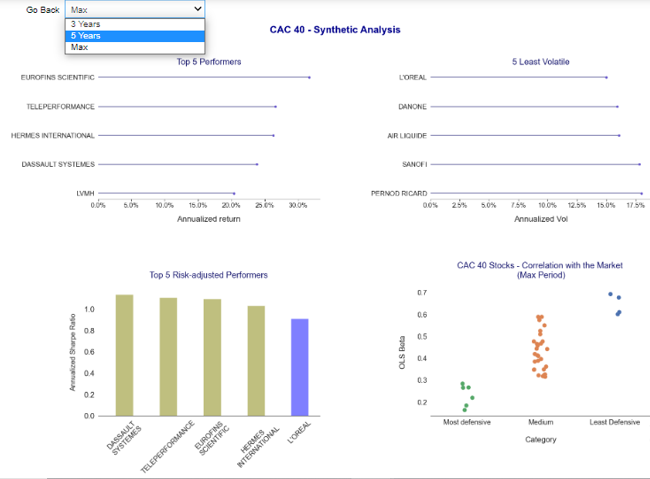

In [88]:
from IPython.display import display,Image
display(Image(filename='widgets screenshot1.png'))

And here is the <b>static</b> version of the plot ( no widgets ) : 

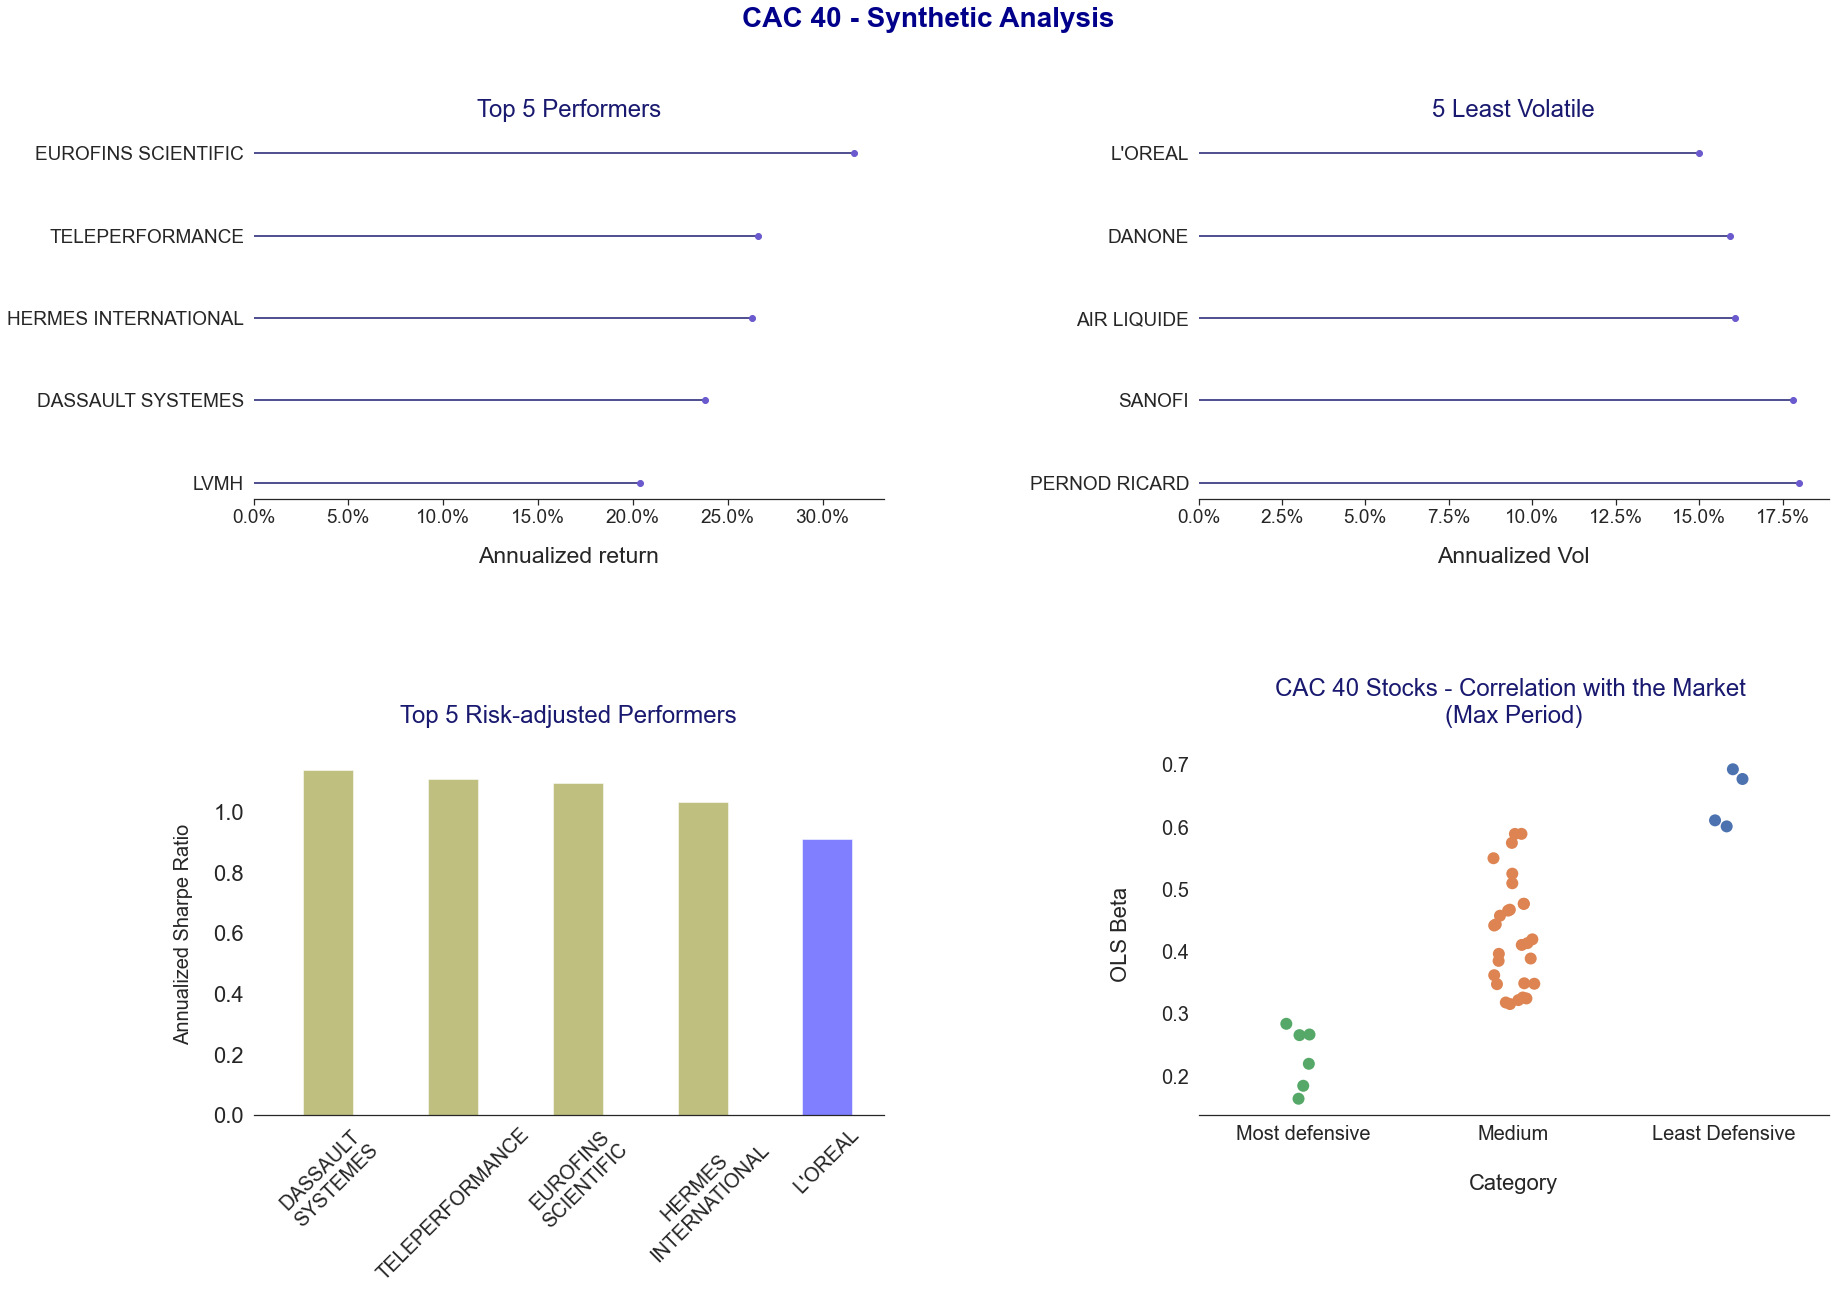

In [38]:
interactive_plot(n_years='Max')

<b>Comments</b> : For the whole period of study (2010-2021 )
- 4 companies out of 38 generated a sharpe ratio that's > 1 . 
- Top 5 performers rendered annualized returns <u><b>over 20%</b></u> which is quite significant . Note that L'oréal does not show among the top 5 performers but is one of the top 5 Risk-adjusted performers , thanks to its low risk ( top 1 least volatile ) . 
- Most of the CAC 40 components belong to the medium catgeory regarding their reaction to the market movements . In other words, if the market goes 1% up or down , most of the stocks , <b><font color='red'>ON AVERAGE</font></b> , go over 0.3% to 0.6%  in the same movement . 

### Part II : Backtesting different investment strategies 

The CAC 40 index itself is already an example of a construction technique wich is cap-weighting . If you want to get the return of CAC 40 ( with a small tracking error ) , you could just buy a CAC 40 ETF and you'd be applying what's called a **passive investment strategy**  . But the goal here is to outperform CAC 40 , which means we're going to change the weights , include certain stocks and exclude others .. . Many construction techniques are available to backtest : 
- Most obvious is <font color='red'>Equal Weighting</font> , also known as the maximum diversification portfolio : this is a <b>naive</b> investment strategy that doesn't require any optimization effort , although it proved to be worth the try 
- 2nd technique is <font color='red'>GMV</font> : global minium variance which minimizes the risk of the portfolio , given a var-cov matrix . Note that this technique is subject to the estimation bias of the var-cov matrix although it <b>does not require the expected return estimate vector</b> that is much harder to determine. 
- 3rd technique is <font color='red'>Max Sharpe Ratio</font> : we'll avoid this one for this project as it requires the expected return estimate vector ( which could be determined through an estimation model like black litterman , but definitely not through a sample-based return vector because it has proven to be not at all reliable ) 
- 4th Technique is <font color='red'>Risk parity</font> : it's a maximum diversification portfolio , not in terms of dollar allocation but in terms of <u><b>risk contribution</b></u> --> it's an allocation such that each constituent contributes equally to the total risk of the portfolio and not to the total value of the portfolio
- 5th technique is <font color='red'>Constrained GMV</font> ( which will further be discussed in a later section ) 
- 6th technique is <font color='red'>Max decorrelation</font> ( will be further discussed in a later section )  

### 1- Equal weighting 

Is CAC 40 really exposed to 40 stocks ? In fact , theory tells us the market cap portfolio ( here the CAC 40 ) is perfectly diversified . Let's verify this . There's a mathematical measure called <font color='red'><b>ENC ( Effective number of constituents )</b></font> that measures the degree of diversification of a given portfolio . ENC is the inverse of the sum of squared weights : Let's compute that .  

In [39]:
ENC=(1/(((df_analysis['Weight']/100)**2).sum()))
round(ENC,2) , str(round(ENC*100/40,2))+'%'

(17.04, '42.6%')

While CAC 40 is theorically composed of 40 stocks , It's effectively exposed to only 17 stocks and is only 42% diversified . 

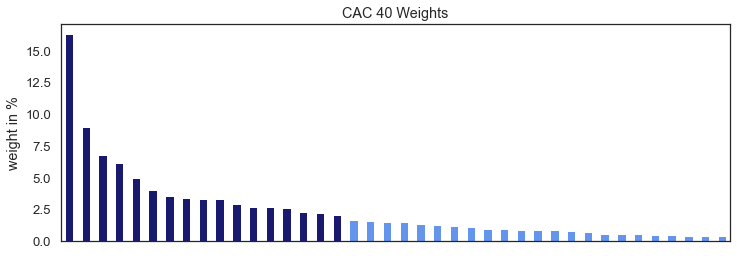

In [40]:
colors=['MidnightBlue']*int(ENC)
colors.extend(['CornFlowerBlue']*(40-int(ENC)))
ax=pd.Series(data=df_analysis['Weight'].to_list(),index=df_analysis['Company']).sort_values(ascending=False).plot.bar(title='CAC 40 Weights',
                                                                                                                     color = colors ,figsize=(12,4)) 
ax.set_xticklabels([])
ax.set_xlabel('')
ax.set_ylabel('weight in %')
plt.show()

This is to tell you that your portfolio can be composed of 1000 stocks but can still be not diversified , because it's only concentrated in certain stocks . In order to get the maximum diversification , you should <u>equally weight</u> your portfolio . 

In [41]:
eq_w=pd.Series(data=[1/38 for i in range(0,38)],index=rets_comp.columns)
ENC_eqw=(1/((eq_w**2).sum()))
ENC_eqw     # effective number of constituents = theorical number of constituents ( 38 ) : remember that we're working on 38 
            # stocks only and not 40 

38.0

In [42]:
# Backtesting the equal weighting scheme : No optimization effort , no need for rolling , this is a naive investment strategy
r_eq=(rets_comp*(1/38)).sum(axis='columns')
r_eq

Date
2010-01   -0.042983
2010-02   -0.003151
2010-03    0.074402
2010-04   -0.019229
2010-05   -0.057902
             ...   
2021-08    0.030000
2021-09   -0.048483
2021-10    0.036855
2021-11   -0.019968
2021-12    0.059710
Freq: M, Length: 144, dtype: float64

In [43]:
# we're going to define a function that returns the performance indicators as well as downside risk measures , given a series
# of returns . 
import scipy.stats as ss
def perf_risk(r):
    ''' r is a pandas Series of returns '''
    # Performance indicators
    ann_ret=((1+r).prod())**(12/r.shape[0])-1
    ann_vol=r.std()*np.sqrt(12)
    excess_ret=(r-rf.squeeze())
    sr=(((1+excess_ret).prod())**(12/r.shape[0])-1)/ann_vol
    
    
    # Risk indicators 
    hvar = -(np.percentile(r,5) )   # 5% historic VaR 
    cvar = -(r[r<-hvar].mean())     # Conditional VaR or expected shortfall 
    skewness = ss.skew(r)     # assymetry of the return distribution 
    kurtosis= ss.kurtosis(r)             # degree of extreme cases ( fatness of the tail )
      # mdd : 
    wi=(1+r).cumprod()
    pp=wi.cummax()
    mdd=-((wi-pp)/pp).min()     
    return pd.Series(data=[ann_ret,ann_vol,sr,hvar,cvar,skewness,kurtosis,mdd],index=['Annualized return','Annualized vol',
                                                                                       'Sharpe Ratio','Historic VaR',
                                                                                      'Expected shortfall','Skewness',
                                                                                      'Kurtosis','MDD'])
                                                                                       

In [44]:
perf_risk(r_eq)

Annualized return     0.096132
Annualized vol        0.166968
Sharpe Ratio          0.511318
Historic VaR          0.069595
Expected shortfall    0.094855
Skewness             -0.091301
Kurtosis              3.540761
MDD                   0.269411
dtype: float64

In [45]:
cac40=rets['CAC 40']
perf_risk(cac40)

Annualized return     0.049324
Annualized vol        0.165098
Sharpe Ratio          0.235632
Historic VaR          0.072158
Expected shortfall    0.096421
Skewness             -0.083654
Kurtosis              1.960667
MDD                   0.274524
dtype: float64

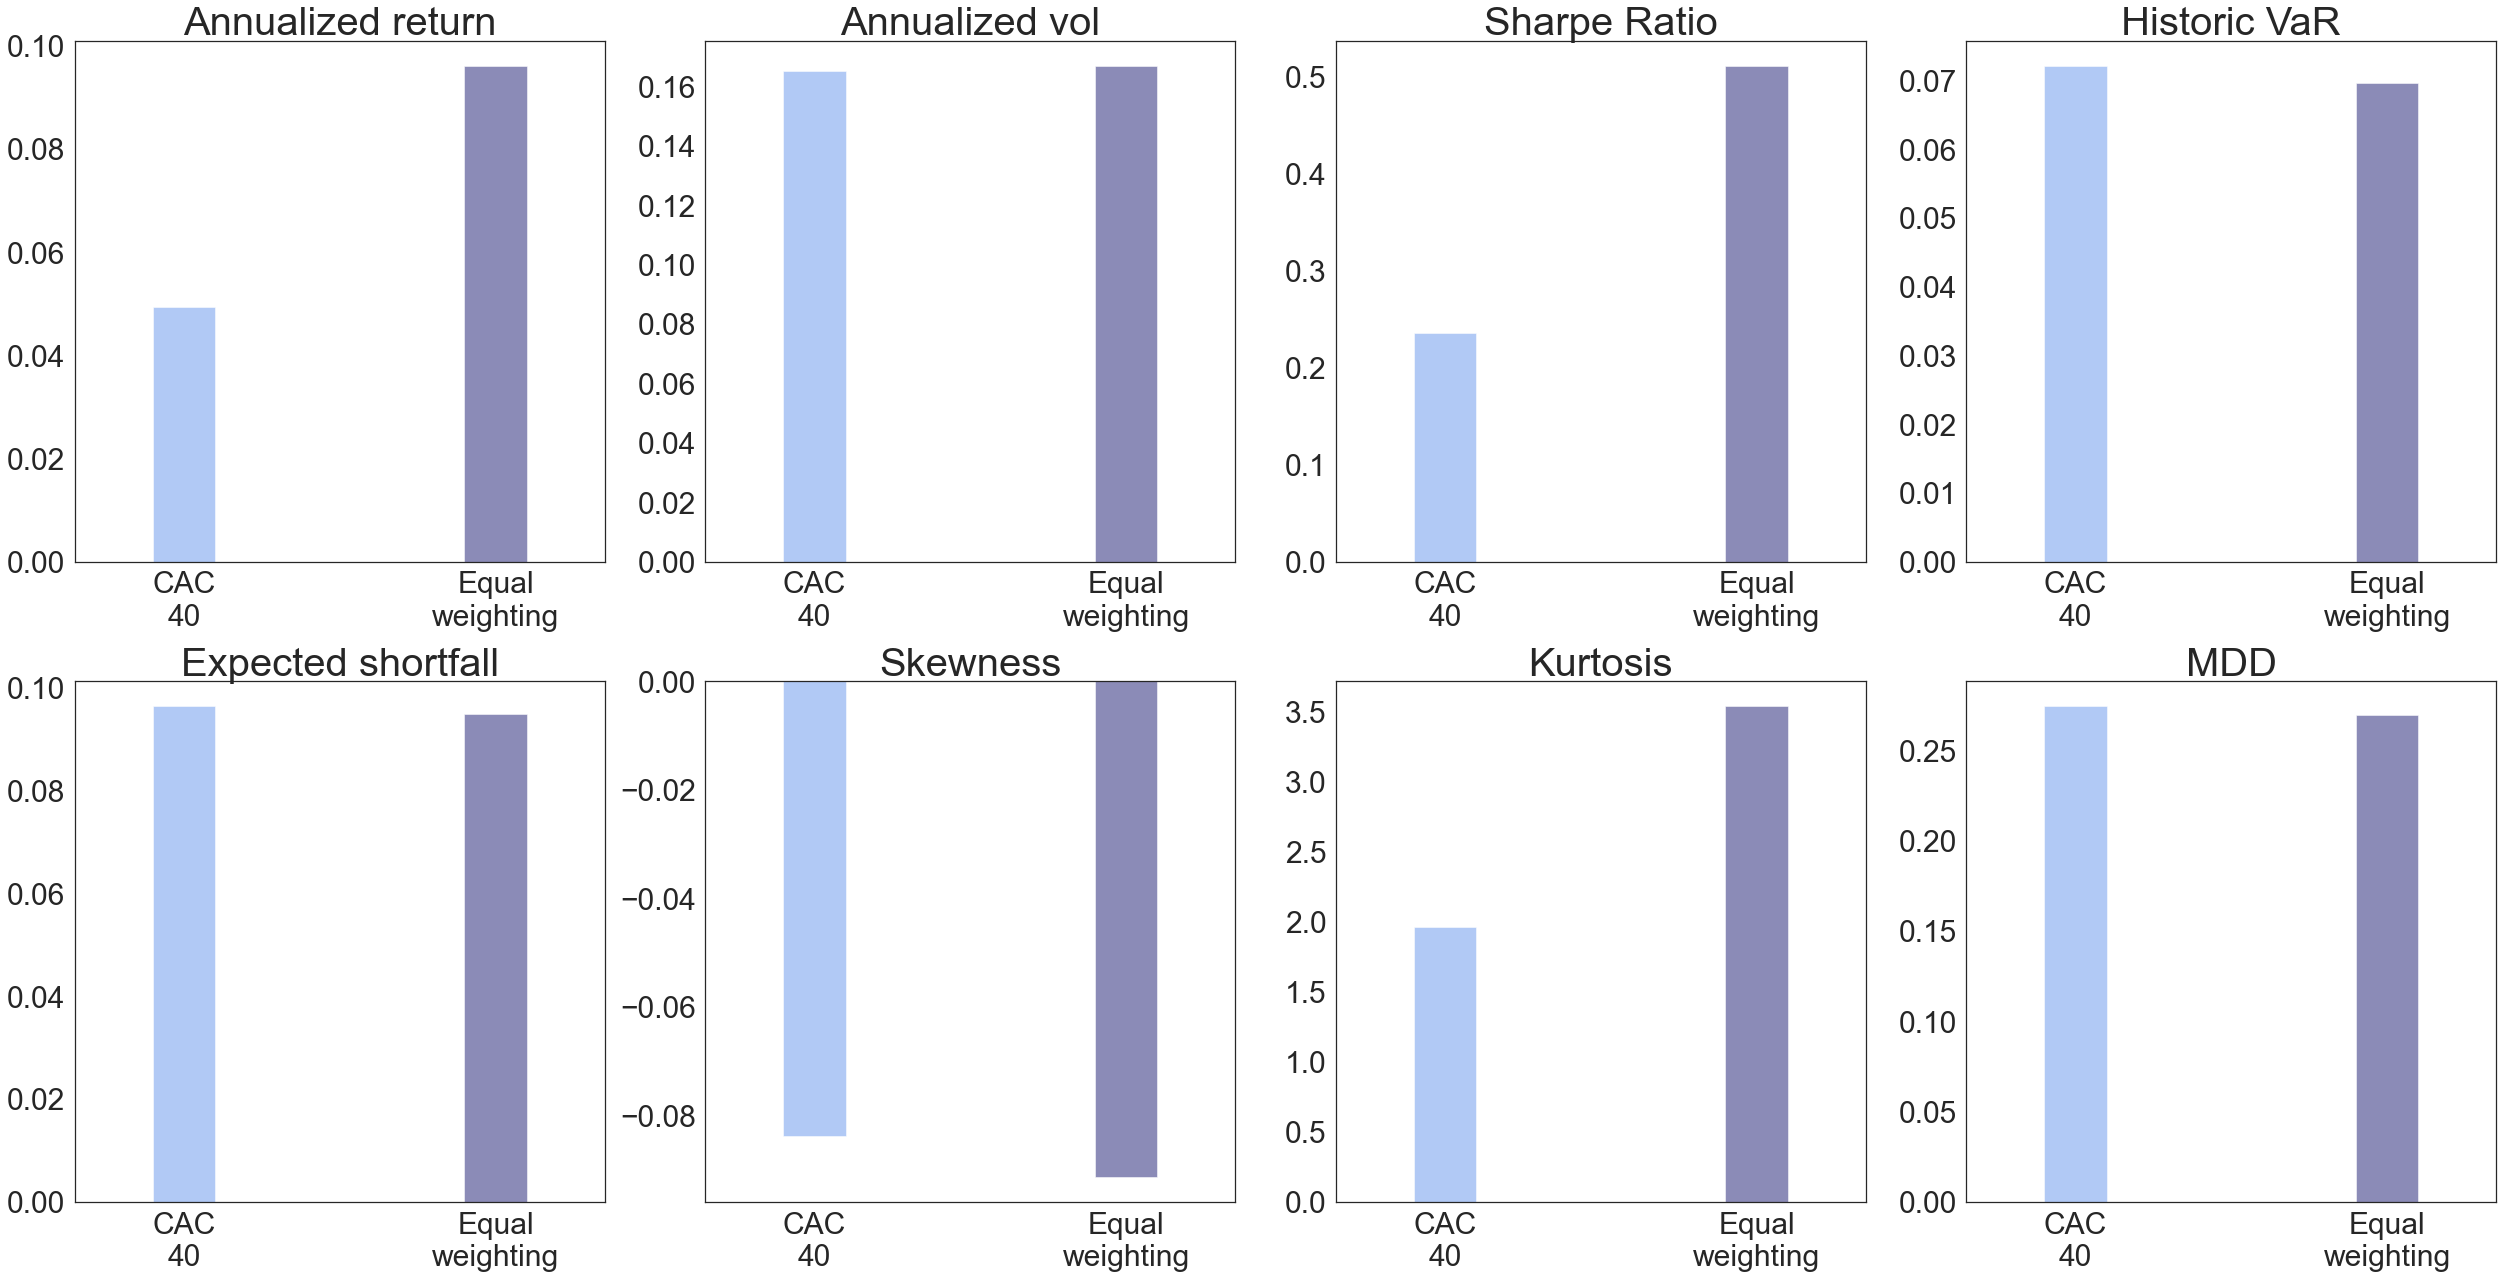

In [47]:
# comparison figure : we have to separate the indicators in different subplots because different measures cannot correspond 
# to the same y-axis . 

comparison=pd.DataFrame({'CAC 40':perf_risk(cac40),'Equal weighting':perf_risk(r_eq)})
i=1
j=1
plt.figure(figsize = (35,18))
for indicator in perf_risk(cac40).index:
    plt.subplot(2,4,i)
    comparison.loc[indicator].plot.bar(rot=0,fontsize=30,color=['cornflowerblue','midnightblue'],width=0.2,alpha=0.5)
    plt.title(label=indicator,fontdict={'fontsize':40})
    wrap_xlabels(plt.subplot(2,4,i))
    plt.tight_layout()
    i=i+1

<b>Striking results</b> : Even the most naive investment strategy <font color='red'>outperformed</font> the CAC 40 ! For many indicators , the equal weighted portfolio is better : better annualized return , better sharpe ratio , less VaR , less Max Drawdown ..  The market portfolio is NOT as perfect as we thought it might be when we were taught financial theory

### 2- GMV : Global Minimum Variance

The goal of this construction technique is to provide the <b>minimum risk given a var-cov matrix</b> . There are different approaches to estimate the cov-matrix : sample based , constant correlation or shrinked matrix which is a mix between sample based and constant correlation approach . I'm going to try the first approach .

Backtesting this technique is different from backtesting the equal weighting scheme : GMV is an optimization program that is fed an estimated var-cov matrix . This cov-matrix needs to be estimated over a historical period . If we estimate this matrix over our whole  period of study ( i.e. : 12 years , last data point excluded ) , we'd feed it to the GMV optimization program , we'd get a set of GMV weights , would apply them to the last data point ( stocks returns at the last date i.e. 2020-12-31 ) and we get ONE weighted average return , corresponding to the last date of our period of study . However , this is not what we want , we want a whole series of weighted average returns , just like CAC 40 or the equal weighting scheme , in order to be able to compute the sharpe ratio , the annualized return ..  . This is where <font color='red'>rolling</font> comes in handy ! We're going to set a <u>rolling window</u> , e.g. 6 months , over which we'll estimate our cov matrix , feed it to the GMV optimization program , get a set of weights , compute the weighted average of the returns of the 7th month using the previously determined weights and get the first data point of our return series --> 1st rolling phase done ! then , roll one month ahead , estimate the cov-matrix over this rolled period , get a new set of weights , compute the weighted average of the return of the 8th month , get the second data point and so on ...  

In [48]:
# define a function to return the GMV weights , given a cov matrix . 
#This function contains an optimization function from scipy library 

from scipy.optimize import minimize
def GMV_w(r,cov_matrix):
    ''' cov_matrix is a parameter type function '''
    init_guess=np.repeat(1/r.shape[1],r.shape[1]) 
    bnds=((0,1),)*r.shape[1]     # Do not go short 
    cons1={'type':'eq','fun':lambda w: w.sum()-1}   
    def vol(w,cov_matrix,r):
        return w.T@cov_matrix(r)@w      # matrix notation of a portfolio volatility
    sol=minimize(vol,init_guess,args=(cov_matrix,r,),method ='SLSQP',bounds=bnds,constraints=[cons1])
    return sol.x
def cov_matrix(r):
    return r.cov()

In [49]:
# Now , roll ! we're going to choose a rolling window of 24 months : that means at each month , we're going to look back 
# 2 years ago to estimate the weights (using the optimization function GMV_w)
r=rets_comp
rolling_window=24
windows=[(x0 , x0+rolling_window) for x0 in range(r.shape[0]-rolling_window)]
w_estimations=[GMV_w(r.iloc[win[0]:win[1]],cov_matrix=cov_matrix) for win in windows]
df_w=pd.DataFrame(w_estimations,index=r.index[rolling_window:],columns=r.columns)

# This will take a while to run because the optimization program is solved for each rolling window 

In [50]:
GMV_backtest=(df_w*r).sum(axis=1,min_count=1)
GMV_backtest   # First 24 returns are NaNs because of rolling ( when rolling , the first rolling window data points are NaNs)
    

Date
2010-01         NaN
2010-02         NaN
2010-03         NaN
2010-04         NaN
2010-05         NaN
             ...   
2021-08    0.058362
2021-09   -0.067472
2021-10    0.046958
2021-11    0.015372
2021-12    0.042693
Freq: M, Length: 144, dtype: float64

In [51]:
# compare the GMV backtest results to cac40 return series 
perf_risk(GMV_backtest.dropna())

Annualized return     0.083213
Annualized vol        0.128815
Sharpe Ratio          0.773310
Historic VaR          0.049742
Expected shortfall    0.081205
Skewness             -0.417877
Kurtosis              0.504217
MDD                   0.173368
dtype: float64

A small detail here is that the previous equaly weighting scheme return series as well as CAC 40's were not obtained by 
rolling . To be able to compare these to the GMV backtest results . We should slice the period so as to begin when 
GMV return series begin ( i.e.: after eliminating the NaNs which corresponds exactly to the rolling window size )

In [52]:
perf_risk(r_eq.iloc[rolling_window:])    

Annualized return     0.128954
Annualized vol        0.162607
Sharpe Ratio          0.898166
Historic VaR          0.062158
Expected shortfall    0.093018
Skewness             -0.084392
Kurtosis              4.986650
MDD                   0.269411
dtype: float64

In [53]:
perf_risk(cac40.iloc[rolling_window:])

Annualized return     0.085133
Annualized vol        0.157423
Sharpe Ratio          0.644913
Historic VaR          0.060975
Expected shortfall    0.090730
Skewness             -0.023284
Kurtosis              3.165839
MDD                   0.264624
dtype: float64

 gain , the <font color='red'>GMV outperformed CAC 40</font> (sharpe ratio of 0.77 vs 0.64 for cac40 ) is clearly much less riskier than CAC 40 (max drawdown drastically less , less kurtosis , vol , VaR ... )  . We're going to test the other strategies to determine the wining one .

### 3-Constrained GMV 

For the standard GMV , it's interesting to see how much it is diversified.Since the weights are not static and are determined 
for each rolling window , we're going to plot a series of ENCs . 

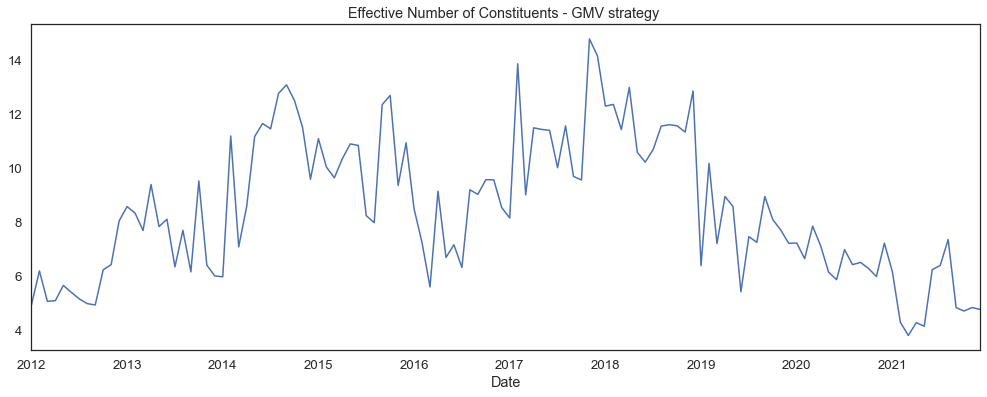

In [54]:
(((df_w**2).sum(axis=1))**(-1)).plot(figsize=(17,6),title='Effective Number of Constituents - GMV strategy ');

<b>Another striking result !</b> the GMV is supposed to be a diversified portfolio ( that's what it's known for ) . How come its effective number of components did not exceed 16 ( out of 38 ) in any of the rolling windows ? What's more , in 2021 the GMV is only ( effectively ) exposed to less than 4 stocks .

In fact , the GMV is NOT a diversified portfolio . It's an optimization program which goal is to minimize the portfolio volatility so , by construction , it will <b>maximize the weights in the least volatile stocks</b> . Indeed , it's a <u>concentrated</u> portfolio in the least volatile stocks .

For this reason , we're going to test another GMV strategy called constrained GMV : **Constrained GMV** , as its name suggests , is a GMV optimization program , only that it's <u>subject to a minimum ENC</u> . Setting the minimum ENC value is normally left to the intuition of the practitioner , but we're going to define an arbitrary one , say 15 stocks. With this constraint , we still want to minimize historical risk but we want to secure a certain degree of diversification . This approach , in a certain way , resembles the <font color='red'>shrinkage approach</font> , where you try to reconcile between 2 opposed objectives to take advantage of both .  


In [62]:
def consGMV_w(r,cov_matrix):
    ''' cov_matrix is a parameter type function '''
    init_guess=np.repeat(1/r.shape[1],r.shape[1]) 
    bnds=((0,1),)*r.shape[1]     # Do not go short 
    cons1={'type':'eq','fun':lambda w: w.sum()-1} 
    cons2={'type':'ineq','fun': lambda w:((w**2).sum())**(-1)-15}   # New constraint : minimum ENC
    def vol(w,cov_matrix,r):
        return w.T@cov_matrix(r)@w      # matrix notation of a portfolio volatility
    sol=minimize(vol,init_guess,args=(cov_matrix,r,),method ='SLSQP',bounds=bnds,constraints=[cons1,cons2])
    return sol.x

In [55]:
def consGMV_w(n_components,cov_matrix):
    init_guess=np.repeat(1/n_components,n_components) 
    bnds=((0,1),)*n_components     # Do not go short 
    cons1={'type':'eq','fun':lambda w: w.sum()-1}   
    cons2={'type':'ineq','fun': lambda w:((w**2).sum())**(-1)-15}   # New constraint : minimum ENC
    def vol(w,cov_matrix):
        return w.T@cov_matrix@w      # matrix notation of a portfolio volatility
    sol=minimize(vol,init_guess,args=(cov_matrix,),method ='SLSQP',bounds=bnds,constraints=[cons1,cons2])
    return sol.x

In [63]:
w_estimations=[consGMV_w(r.iloc[win[0]:win[1]],cov_matrix=cov_matrix) for win in windows]  # takes a while to run(around 1 min)
df_w=pd.DataFrame(w_estimations,index=r.index[rolling_window:],columns=r.columns)

In [64]:
consGMV_backtest=(df_w*r).sum(axis=1,min_count=1)
consGMV_backtest


Date
2010-01         NaN
2010-02         NaN
2010-03         NaN
2010-04         NaN
2010-05         NaN
             ...   
2021-08    0.042772
2021-09   -0.094470
2021-10    0.042211
2021-11    0.022192
2021-12    0.034859
Freq: M, Length: 144, dtype: float64

In [65]:
perf_risk(consGMV_backtest.dropna())

Annualized return     0.097043
Annualized vol        0.130061
Sharpe Ratio          0.874038
Historic VaR          0.050423
Expected shortfall    0.086214
Skewness             -0.617135
Kurtosis              1.489903
MDD                   0.191619
dtype: float64

With the new constraint introduced , we managed to increase the Sharpe ratio  <font color='red'><b>from 0.77 to 0.87</b></font> . However , risk indicators increased , although very slightly ( MDD , VaR , kurtosis .. ) . This is to show you that Constrained GMV is an interesting strategy to look at and that we can easily create <u><b>many variants of GMV</b></u> in an attempt to improve it or adapt it to our needs . In fact , a point of view to note here is saying that concentrating your portfolio in the least risky stocks does not necessarily reduce risk , even though it rends you minimum HISTORICAL risk : remember that the vols fed to the optimization program are sample-based ! Thus , we might want to  diversify our portfolio rather than concentrating it in the least risky stocks ,  in an attempt to reduce <b>future risk</b> . This is where constrained GMV gets its intuition. 

### 4- Risk Parity

Diversification can be defined in two ways : There's **the diversification in dollar value** and **the diversification in terms of risk contribution** . The former is the standard <font color='red'>equal weighting</font> scheme saw above . The latter is the <font color='red'>risk parity</font> portfolio , where each stock equally contributes to the total risk of the portfolio . Again , we need an estimation of the var-cov matrix over a historical period and an optimization program to compute the weights such that the risk contributions are equal . We're also going to roll when backtesting . 

In [66]:
# Rolling in backtesting is repetitive among many construction techniques . So we're going to define a function that rolls 
# and returns backtested results . 
def roll_backtest(cons_technique,r,**kwargs):
    ''' cons_technique is a function : it should return the weights for a given rolling window . r is a dataframe of the return
    series of the components .
    '''
    windows=[(x0,x0+rolling_window) for x0 in range(r.shape[0]-rolling_window)]
    w_estimations=[cons_technique(r.iloc[win[0]:win[1]],**kwargs) for win in windows]
    df_w=pd.DataFrame(data=w_estimations , index=r.index[rolling_window:],columns=r.columns)
    backtest_r=(df_w*r).sum(axis=1,min_count=1)
    return backtest_r

In [67]:
# define a function to return risk parity weights , like we did for GMV and constrained GMV ( all of these are optimization 
# programs ).
def risk_contributions(w,r):
    ''' This is a helper function that we're going to use in the risk parity optimization function . 
    w is an array or series of weights . r is a dataframe of the return series of the components .  
    '''
    nominator=w* ((r.cov())@w)
    prtf_vol=w.T@(r.cov())@w
    return nominator/prtf_vol


def risk_parity(r):
    ''' r is the dataframe of the return series of the components . The idea of this optimization program is to minimize
    the tracking error between the risk contributions of the portfolio to optimize and the equal risk contributions '''
    init_guess=np.repeat(1/r.shape[1],r.shape[1])
    bnds=((0,1),)*r.shape[1]
    cons1={'type':'eq','fun':lambda w:w.sum()-1}
    def tracking_error(w,r):
        return ((risk_contributions(w,r)-np.repeat(1/r.shape[1],r.shape[1]))**2).sum()
    sol=minimize(tracking_error,init_guess,args=(r,),method='SLSQP',bounds=bnds,constraints=[cons1])
    return sol.x

In [68]:
riskpar_backtest=roll_backtest(risk_parity,r)
riskpar_backtest 

Date
2010-01         NaN
2010-02         NaN
2010-03         NaN
2010-04         NaN
2010-05         NaN
             ...   
2021-08    0.037410
2021-09   -0.065820
2021-10    0.039228
2021-11    0.002887
2021-12    0.045652
Freq: M, Length: 144, dtype: float64

In [69]:
perf_risk(riskpar_backtest.dropna())

Annualized return     0.119831
Annualized vol        0.143401
Sharpe Ratio          0.953870
Historic VaR          0.057985
Expected shortfall    0.086708
Skewness             -0.396721
Kurtosis              3.283241
MDD                   0.231183
dtype: float64

So far , the risk parity portfolio generated <font color='red'>the best risk adjusted performance</font> ( Sharpe Ratio of <u>0.95</u> ) . The risk indicators are more or less comparable to the other investment strategies . We're going to synthetize all these differences in a later plot . 

### 5-Max Decorrelation portfolio 

This construction technique assumes that <font color='red'>all stocks have the same volatility</font> . Why ? In fact , we know that the optimization program of the GMV minimizes the volatility of the portfolio . If the individual vols are all the same , the optimization function won't look at the least volatile stocks and concentrate the allocation in them ( because the individual volatility effect is neutralized assuming that they're all equal ) , but the focus will be reoriented to the correlation effect hence the name <b>max decorrelation</b> . In other words , the optimization function will not anymore count on the least risky stocks but will <u><b>count on their decorrelation</b></u> to minimize the total volatility .  

In [71]:
# Fortunately , we don't have to write another optimization program . We can use the GMV program and replace the cov matrix with
# the correlation matrix and that will give us a portfolio vol that only depends on the correlations . 
def corr_matrix(r):
    return r.corr()
maxdecor_backtest=roll_backtest(cons_technique=GMV_w,r=r,cov_matrix=corr_matrix)
maxdecor_backtest

Date
2010-01         NaN
2010-02         NaN
2010-03         NaN
2010-04         NaN
2010-05         NaN
             ...   
2021-08    0.090831
2021-09   -0.053604
2021-10    0.043202
2021-11    0.070617
2021-12    0.007605
Freq: M, Length: 144, dtype: float64

In [72]:
perf_risk(maxdecor_backtest.dropna())

Annualized return     0.129876
Annualized vol        0.159270
Sharpe Ratio          0.923246
Historic VaR          0.068884
Expected shortfall    0.093854
Skewness             -0.300439
Kurtosis              0.370613
MDD                   0.258878
dtype: float64

In [73]:
# Now synthetize all investment strategies ( 5 --> equal weighting , GMV , constrained GMV , Risk Parity , Max Decorrelation): 
# Which one performed best in terms of risk-reward , according to the backtest ?

strategy=pd.DataFrame(['Max Decorrelation','Risk Parity','Constrained GMV','GMV','CAC 40','Equal Weighting'],columns=['Strategy'])
df_perfrisk=pd.concat([strategy,pd.concat([perf_risk(maxdecor_backtest.dropna()),perf_risk(riskpar_backtest.dropna()),
                       perf_risk(consGMV_backtest.dropna()),perf_risk(GMV_backtest.dropna()),
                            perf_risk(cac40.iloc[rolling_window:]),perf_risk(r_eq.iloc[rolling_window:])],axis=1).T],axis=1)


df_perfrisk

,Strategy,Annualized return,Annualized vol,Sharpe Ratio,Historic VaR,Expected shortfall,Skewness,Kurtosis,MDD
0,Max Decorrelation,0.129876,0.159270,0.923246,0.068884,0.093854,-0.300439,0.370613,0.258878
1,Risk Parity,0.119831,0.143401,0.953870,0.057985,0.086708,-0.396721,3.283241,0.231183
2,Constrained GMV,0.097043,0.130061,0.874038,0.050423,0.086214,-0.617135,1.489903,0.191619
3,GMV,0.083213,0.128815,0.773310,0.049742,0.081205,-0.417877,0.504217,0.173368
4,CAC 40,0.085133,0.157423,0.644913,0.060975,0.090730,-0.023284,3.165839,0.264624
5,Equal Weighting,0.128954,0.162607,0.898166,0.062158,0.093018,-0.084392,4.986650,0.269411


In [76]:
# Now , create a bubble chart to show the ranking . I found this chart in a towardsdatascience article which suggests many 
# aesthetic charts other than the Bar chart that are interesting to look at . I also added widgets to select the 
# desired indicator and display the corresponding ranking.
# Article URL : https://towardsdatascience.com/9-visualizations-that-catch-more-attention-than-a-bar-chart-72d3aeb2e091

def get_color(name, number):
    pal = list(sns.color_palette(palette=name, n_colors=number).as_hex())
    return pal
pal_vi = get_color('viridis_r', df_perfrisk.shape[0])

def interactive_bubble(indicator):
    df_perfrisk_s=df_perfrisk.sort_values(by=indicator,ascending=False)
    df_perfrisk_s['X']=[5]*df_perfrisk_s.shape[0]
    lst=list(range(0,df_perfrisk_s.shape[0]))
    lst.reverse()
    df_perfrisk_s['Y']=lst
    df_perfrisk_s['labels']=['<b>'+i+'<br>'+str(round(j,3)) for i,j in zip(df_perfrisk_s['Strategy'],df_perfrisk_s[indicator])]

    fig = px.scatter(df_perfrisk_s, x='X', y='Y',
                     color='Strategy', color_discrete_sequence=pal_vi,
                     size=indicator, text='labels' ,size_max=50 , )

    fig.update_layout(width=900, height=500,
                      margin = dict(t=0, l=0, r=0, b=0),
                      showlegend=False)

    fig.update_traces(textposition='middle right')
    fig.update_xaxes(showgrid=False, zeroline=False, visible=False)
    fig.update_yaxes(showgrid=False, zeroline=False, visible=False)

    fig.update_layout({'plot_bgcolor': 'white',
                       'paper_bgcolor': 'white'},font=dict(size=18))

    fig.show()

lst_indicators=list(df_perfrisk.drop(['Strategy','Skewness'],axis=1).columns) # eliminate skewness from the drop down list because the size parameter in the bubble chart cannot be negative
widgets.interact(interactive_bubble,indicator=widgets.Dropdown(options=lst_indicators,description='<font size="3">Indicator',value='Sharpe Ratio'));

interactive(children=(Dropdown(description='<font size="3">Indicator', index=2, options=('Annualized return', 'Annualized vol', 'Sharpe Ratio', 'Historic VaR', 'Expected shortfall', 'Kurtosis', 'MDD'), value='Sharpe Ratio'), Output()), _dom_classes=('widget-interact',))

As we said , ipywidgets cannot be displayed on github . if you download the notebook and run it, you can view widgets and interact with the plot . Here is just <b><u>a screenshot of the output</u></b>  : 

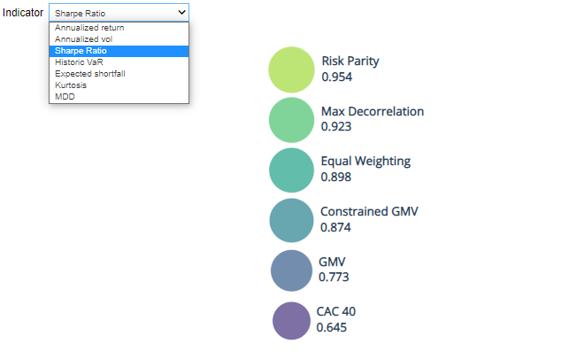

In [90]:
display(Image(filename='widgets screenshot2.png'))

And here is the <b>static</b> version of the plot ( no widgets ) : 

In [78]:
interactive_bubble('Sharpe Ratio')

<b>Comments:</b> 
- Note that for risk indicators , bigger bubbles (which appear at the top ) are worse . e.g.: Equal weighting and CAC 40 show 
the highest risk in terms of max drawdown ! 


- <u>Risk Parity is the <font color='red'>winner strategy</font> in terms of risk-reward trade-off</u>, generating a Sharpe ratio of 0.95 . This means that <b>for each additional percentage point of risk</b> , the Risk Parity portfolio renders an <b>additional 0.95% excess return</b> : Not the perfect result because we'd prefer a sharpe ratio > 1 , but it's still the winning strategy with an additional 0.3% excess return per unit of risk over the CAC 40 .  Regarding the risk indicators , Risk Parity is , except for the kurtosis , in the 3rd place out of 6 investment strategies which is acceptable .


- Finally , it's interesting to note that CAC 40 , which we theorically thought is the perfect portfolio that all investors would want to hold , is <b>ranked last</b> .

### Part III : Applying the CPPI strategy

Now we have the return series of our chosen portfolio ( backtested risk parity return series ) , which ,as previously said, 
will represent the risky part of the total portfolio . The next step is to choose a safe asset to include in this portfolio . 
For the CPPI strategy to work , the safe asset should render >=0 returns . 
I chose a savings account ( Livret A ) to represent the safe asset ( although it's close to not investing at all because the rates are excessively low ) but there's practically no other option with the free available data on web . Choosing french government bonds ( OAT ) is not a good idea since they've been rendering negative rates lately ( 2019-2020-2021) .

In [79]:
# Starting from 2012 , Livret A rates are the following : 
lvrtA_rates=pd.Series([0.0225 , 0.0175 , 0.0125 , 0.01 , 0.0075])     
lvrtA_ratesm=lvrtA_rates/12    # because lvrtA_rates are annual 
# Changing the rates occured on the following dates : 
change_dates=['2013-02','2013-08','2014-08','2015-08']
# construct the safe return series with the above informations
safe_ret=pd.Series().reindex_like(riskpar_backtest.dropna())
safe_ret.iloc[0]=lvrtA_ratesm[0]
safe_ret.loc[change_dates]=lvrtA_ratesm.iloc[1:].to_list()

In [80]:
safe_ret=safe_ret.ffill()   
safe_ret

Date
2012-01    0.001875
2012-02    0.001875
2012-03    0.001875
2012-04    0.001875
2012-05    0.001875
             ...   
2021-08    0.000625
2021-09    0.000625
2021-10    0.000625
2021-11    0.000625
2021-12    0.000625
Freq: M, Length: 120, dtype: float64

In [81]:
risky_ret=riskpar_backtest.dropna()
risky_ret

Date
2012-01    0.054582
2012-02    0.046231
2012-03    0.030523
2012-04   -0.043528
2012-05   -0.045318
             ...   
2021-08    0.037410
2021-09   -0.065820
2021-10    0.039228
2021-11    0.002887
2021-12    0.045652
Freq: M, Length: 120, dtype: float64

The idea of the CPPI strategy is based on <u>2 assumptions</u> :

<font color='red'>1/</font> How much loss do we expect the risky part of our portfolio to undergo at MAXIMUM , in a SINGLE MONTH , during the investment horizon ? --> suppose we expect a maximum loss of 20%  . 

<font color='red'>2/</font> What is the tolerated maximum drawdown during the investment horizon ? --> suppose we don't want to lose more that 20% of our capital . 

Any monthly loss of the risk parity backtested portfolio that exceeds the expected loss ( 20% )  , if not compensated by the safe return ( which won't be because the safe returns are insignificant here ) , <b>will cause us to breach our floor</b> ! 

You can play with these parameters ( using widgets ) , but for now the 2 chosen values seem fairly reasonable . 

Let's apply the CPPI strategy : the CPPI strategy program will determine the monthly weights to allocate to the risky portfolio and the savings account such that we don't lose more than 20% ( cumulative loss and not discrete ) . 

In [82]:
# CPPI program 
def cppi(exp_loss,max_dd):
    value_prtf=1000  # suppose this is the initial capital to allocate
    prev_peak=value_prtf 
    s_value_prtf=pd.Series().reindex_like(safe_ret)
    s_floor=pd.Series().reindex_like(safe_ret)
    s_w_riskpar=pd.Series().reindex_like(safe_ret)
    for i in range(risky_ret.shape[0]):
        prev_peak=np.maximum(prev_peak,value_prtf)
        floor=(1-max_dd)*prev_peak  # the floor changes according to the previous peak , i.e. If the value of my portfolio became 
                                    # 2000 for e.g. at some point in time , I wouldn't want to have less than 1800 even though I 
                                    # started off at the begining with only 1000 
        w_riskpar=((value_prtf-floor)*1/exp_loss)/value_prtf
        w_riskpar=np.maximum(w_riskpar,0)    # Do not go short 
        w_riskpar=np.minimum(w_riskpar,1)
        value_prtf=w_riskpar*value_prtf*(1+risky_ret.iloc[i])+(1-w_riskpar)*value_prtf*(1+safe_ret.iloc[i])
        s_value_prtf.iloc[i]=value_prtf
        s_floor.iloc[i]=floor
        s_w_riskpar.iloc[i]=w_riskpar
    return pd.DataFrame({'Portfolio value with CPPI': s_value_prtf,'floor':s_floor,
                          'No CPPI-100% stocks':(1000*(1+risky_ret).cumprod())})

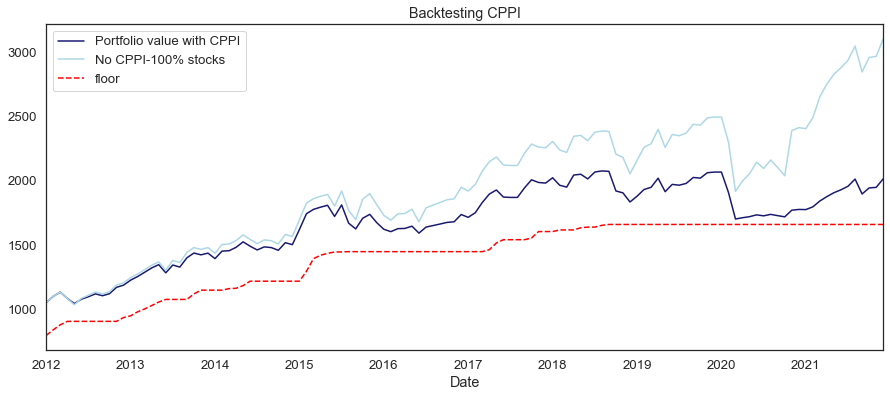

In [83]:
# displaying the backtested results
cppi(0.2,0.2)['Portfolio value with CPPI'].plot(figsize=(15,6),color='midnightblue',title='Backtesting CPPI')
cppi(0.2,0.2)['No CPPI-100% stocks'].plot(color='lightblue')
cppi(0.2,0.2)['floor'].plot(linestyle='--',color='red')
plt.legend();

<font color='red'>Definitely not a good idea to apply the CPPI strategy in this case !</font> Many reasons could explain why the backtest is showing no use of this strategy : our risk parity portfolio is already fairly diversified which prevented extreme losses . Also , the period of investment only includes the covid crash in 2020 , but not the 2008 crash or the dotcom bubble where the drops were much stepper . Investigating the return series of our risk parity portfolio gives this : 

In [84]:
print(risky_ret.min(),'-',risky_ret.idxmin()) # the max monthly loss observed is 16% ( during the covid-crisis)

-0.16624535892807496 - 2020-03


<b>CPPI helps you on the downside but not on the upside</b> : if there are no extreme losses , a risky strategy would certainly outperform the risk-averse strategy,which is the case here. To illustrate the use of the CPPI strategy , let's consider this hypothetical situation : suppose that our risk parity portfolio has undergone <font color='red'>more negative returns</font> ( say -20% and another -15% some other time ) , let's see what the CPPI portfolio would have behaved <b>vs</b> what could've happened to our potfolio without CPPI.

In [85]:
# hypothetical situation 
risky_ret.iloc[80]=-0.2      
risky_ret.iloc[100]=-0.15

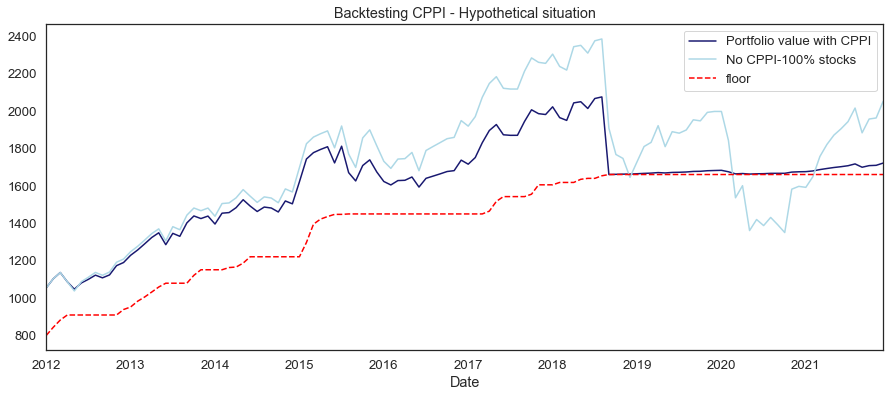

In [86]:
# Backtesting the hypothetical situation
cppi(0.2,0.2)['Portfolio value with CPPI'].plot(figsize=(15,6),color='midnightblue',title='Backtesting CPPI - Hypothetical situation')
cppi(0.2,0.2)['No CPPI-100% stocks'].plot(color='lightblue')
cppi(0.2,0.2)['floor'].plot(linestyle='--',color='red')
plt.legend();

In this situation , you can see that CPPI is a life saver for someone who's <u><b>risk averse</b></u>. The portfolio value smoothly remained <font color = 'red'>above the floor</font> , while the <b>No-CPPI-portfolio</b> clearly <font color='red'>breached it</font> causing a max drawdown that's way above the one tolerated (i.e.:20% ). You can also see that , on the updside parts , the CPPI portoflio has a poor performance compared to the No-CPPI-portfolio . And after the dramatic loss in 2020 , the No-CPPI-portfolio agressively bounced while the CPPI portfolio remained steady or slightly increased . This is a practical illustration of what we call <font color='red'><u><b>'THERE'S NO FREE LUNCH IN FINANCE'</b></u></font> .

### Conclusion

Over the considered period of study( 2010-2021 ) , the selected construction technique is Risky Parity ( best risk-adjusted performer ) , according to the backtest results . The CPPI strategy showed to be not really useful over the period of study , however could be of use in the future , at times where one expects some more frequent and greater losses ( e.g. : first semester of the year 2022 characterized by its uncertainty due to the ukraine crisis ) . 

The period of study I chose is static ( it stops at 2021 )  and that's because I wrote interpretations of graphs which can change if the period of study expands . Otherwise , It could be a good idea to make this notebook <font color='red'>dynamic</font> by computing the date at the time of the code execution using these 2 lines of code (from datetime import datetime / datetime.today().strftime('%Y-%m-%d' ), assign this to a variable and replace the stop date in the yahoo finance request line by this variable . This would update the backtest and give us more reliable results ! 